In [113]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from norse.torch.functional.lif import LIFParameters
from norse.torch.functional.lif_refrac import LIFRefracParameters
from tqdm import tqdm

from cgtasknet.instruments.dynamic_generate import SNNStates
from cgtasknet.instruments.instrument_pca import PCA
from cgtasknet.net.lifrefrac import SNNLifRefrac
from cgtasknet.net.states import LIFRefracInitState
from cgtasknet.tasks.reduce import DefaultParams, RomoTask

dmparams1 = DefaultParams("RomoTask").generate_params()
dmparams1["delay"] = 0.1
dmparams1["trial_time"] = 0.15
dmparams1["values"] = (0.7, 0.5)
Task = RomoTask(dmparams1, mode="value")

dmparams2 = DefaultParams("RomoTask").generate_params()
dmparams2["delay"] = 0.1
dmparams2["trial_time"] = 0.15
dmparams2["values"] = (0.7, 0.9)
Task2 = RomoTask(dmparams2, mode="value")


feature_size = 2
output_size = 3
hidden_size = 600
batch_size = 1
neuron_parameters = LIFRefracParameters(
    LIFParameters(
        tau_mem_inv=torch.as_tensor(1 / 0.01),
        alpha=torch.as_tensor(100),
        method="super",
        v_th=torch.as_tensor(0.65),
    ),
    rho_reset=torch.as_tensor(1),
)
model = SNNLifRefrac(
    feature_size,
    hidden_size,
    output_size,
    neuron_parameters=neuron_parameters,
    tau_filter_inv=500,
)
if True:
    model.load_state_dict(
        torch.load("..\models\\only_romo_lif_refrac\\Only_romo_lif_refrac_net_600")
    )
init_state = LIFRefracInitState(batch_size, hidden_size)
first_state = init_state.zero_state()
second_state = init_state.random_state()
inputs, target_out = Task.dataset(1)
one_trajectory_time = inputs.shape[0] * 2 - 2  # - 2 + 1500 + 1500
v_mean = torch.zeros((one_trajectory_time, batch_size, hidden_size))
number_of_trials = 20
for trial in tqdm(range(number_of_trials)):
    inputs, target_out = Task.dataset(1)

    data = inputs  # + np.random.normal(0, 0.01, size=(inputs.shape))
    inputs2, target_out2 = Task2.dataset(1)
    data2 = inputs2  # + np.random.normal(0, 0.01, size=(inputs2.shape))
    # inputs3, target_out3 = Task3.dataset(1)
    # data3 = inputs3 + np.random.normal(0, 0.01, size=(inputs3.shape))
    # inputs4, target_out4 = Task4.dataset(1)
    # data4 = inputs4 + np.random.normal(0, 0.01, size=(inputs4.shape))

    # data = np.concatenate((data, np.zeros((500, data.shape[1], data.shape[2]))))
    data = np.concatenate((data, data2), axis=0)
    # data = np.concatenate((data, np.zeros((500, data.shape[1], data.shape[2]))))
    # data = np.concatenate((data, data3))
    # data = np.concatenate((data, np.zeros((500, data.shape[1], data.shape[2]))))
    # data = np.concatenate((data, data4))
    # data = np.concatenate((data, np.zeros((1500, data.shape[1], data.shape[2]))))

    data = torch.from_numpy(data).type(torch.float32)

    # target_out = torch.from_numpy(target_out).type(torch.float)

    states_generator = SNNStates(model)
    out, states = states_generator.states(data, first_state)
    v = []
    s = []
    i = []
    for j in range(len(states)):
        v.append(states[j].lif.v)
        s.append(states[j].lif.z)
        i.append(states[j].lif.i)
    v = torch.stack(v).detach()
    # s = torch.stack(s).detach()
    # i = torch.stack(i).detach()
    # plt.plot(data[:, 0, 7])
    # plt.plot(out.detach().cpu().numpy()[:, 0, 3])
    # plt.plot(out.detach().cpu().numpy()[:, 0, 4])
    # plt.show()
    v_mean += v
v_mean /= float(number_of_trials)
pca = PCA(3).decompose(v_mean.reshape(v_mean.shape[0], v_mean.shape[2]))
cmap = np.arange(0, len(v_mean))

100%|██████████| 20/20 [00:25<00:00,  1.25s/it]


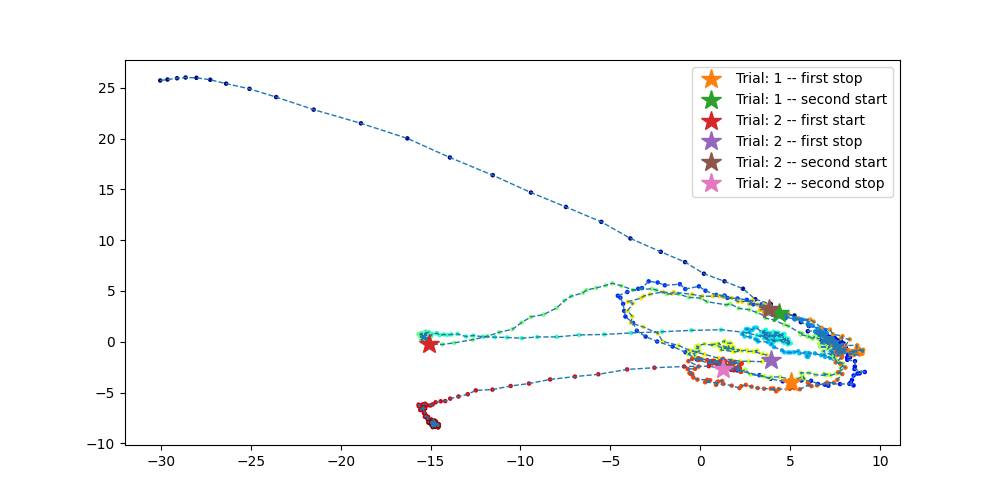

In [108]:

%matplotlib widget
first = 0
second = 1
plt.figure(figsize=(10, 5))

plt.plot(pca.numpy()[:, first], pca.numpy()[:, second], "--", linewidth=1)
plt.scatter(pca.numpy()[:, first], pca.numpy()[
            :, second], c=cmap, cmap="jet", s=5)


class PlotTimes:
    delay = int(dmparams1['delay'] / dmparams1['dt'])
    trial = int(dmparams1['trial_time'] / dmparams1['dt'])


trial_1_stop_first = PlotTimes.trial
trial_1_start_second = PlotTimes.delay + PlotTimes.trial

trial_2_start_first = trial_1_start_second + PlotTimes.trial + PlotTimes.delay
trial_2_stop_first = trial_2_start_first + PlotTimes.trial
trial_2_start_second = trial_2_stop_first + PlotTimes.delay
trial_2_stop_second = trial_2_start_second + PlotTimes.trial
msize = 15
plt.plot(pca.numpy()[trial_1_stop_first, first], pca.numpy()[
         trial_1_stop_first, second], '*',  markersize = msize, label='Trial: 1 -- first stop')
plt.plot(pca.numpy()[trial_1_start_second, first], pca.numpy()[
         trial_1_start_second, second], '*', markersize = msize,  label='Trial: 1 -- second start')

plt.plot(pca.numpy()[trial_2_start_first, first], pca.numpy()[
         trial_2_start_first, second], '*', markersize = msize,  label='Trial: 2 -- first start')

plt.plot(pca.numpy()[trial_2_stop_first, first], pca.numpy()[
         trial_2_stop_first, second], '*', markersize = msize,  label='Trial: 2 -- first stop')

plt.plot(pca.numpy()[trial_2_start_second, first], pca.numpy()[
         trial_2_start_second, second], '*', markersize = msize,  label='Trial: 2 -- second start')
plt.plot(pca.numpy()[trial_2_stop_second, first], pca.numpy()[
         trial_2_stop_second, second], '*', markersize = msize,  label='Trial: 2 -- second stop')
plt.legend()


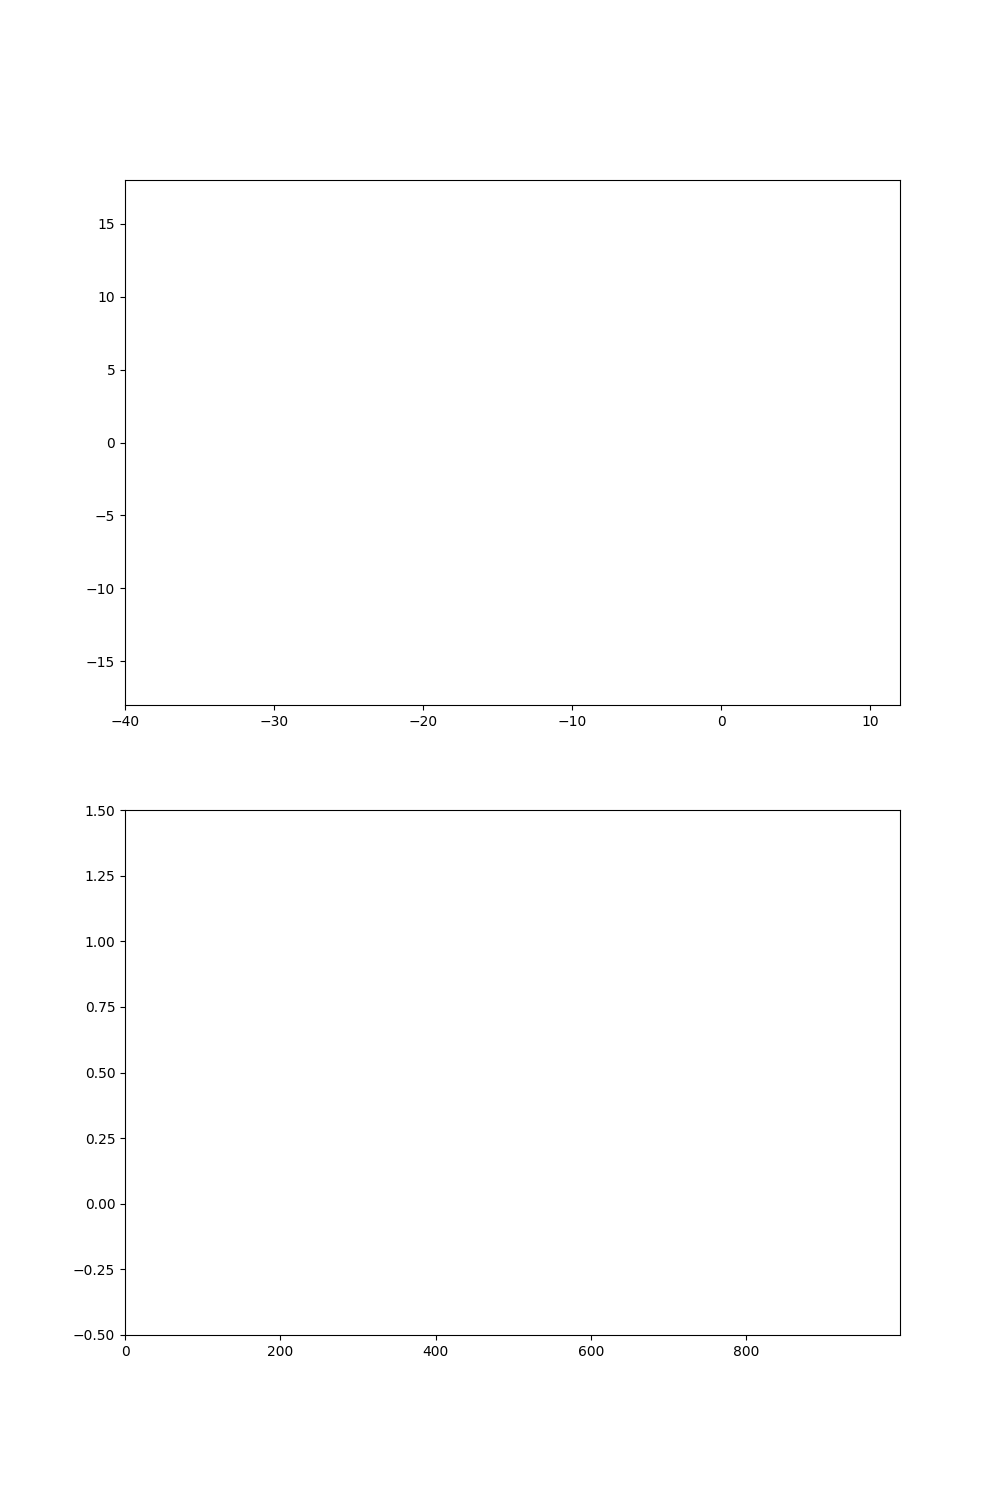

In [111]:
%matplotlib widget
plt.ion
fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(211)
ax.set_xlim(-40, 12)
ax.set_ylim(-18, 18)

ax2 = fig.add_subplot(212)
ax2.set_xlim([0, len(pca)])
ax2.set_ylim([-0.5, 1.5])
line, = ax.plot(1, 1)
line2, = ax.plot(1, 1)
fig.canvas.draw()
fig.canvas.flush_events()



In [112]:
import time


def update():
    for i in range(0, len(pca), 1):
        first = 0
        second = 1

        # plt.clf()
        ax.set_xlim(-40, 12)
        ax.set_ylim(-18, 18)

        ax2.set_xlim([0, len(pca)])
        ax2.set_ylim([-0.5, 1.5])
        ax.clear()
        ax.scatter(pca.numpy()[:i, first], pca.numpy()[:i, second], c="black", s=2)
        ax.plot(
            pca.numpy()[:i, first],
            pca.numpy()[:i, second],
            "--",
            c="black",
            linewidth=0.1,
        )

        ax2.clear()
        ax2.plot(data.numpy()[:i, 0, 1], c="black")
        fig.canvas.draw()
        fig.canvas.flush_events()
        # time.sleep(.001)


# while True:
update()

KeyboardInterrupt: 

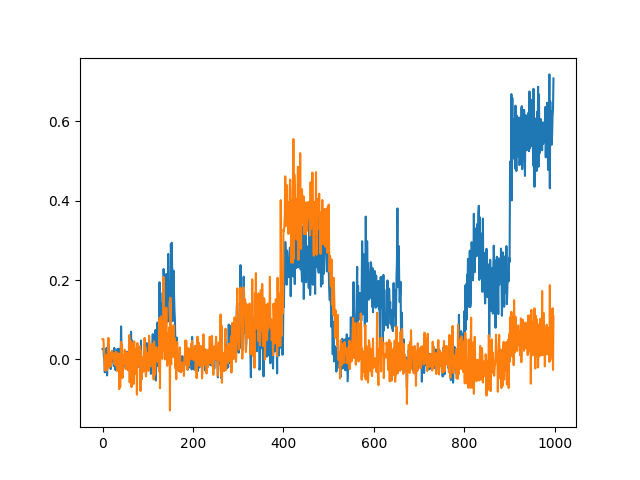

In [110]:
plt.figure()
plt.plot(out.detach().cpu().numpy()[:, 0, 1])
plt.plot(out.detach().cpu().numpy()[:, 0, 2])

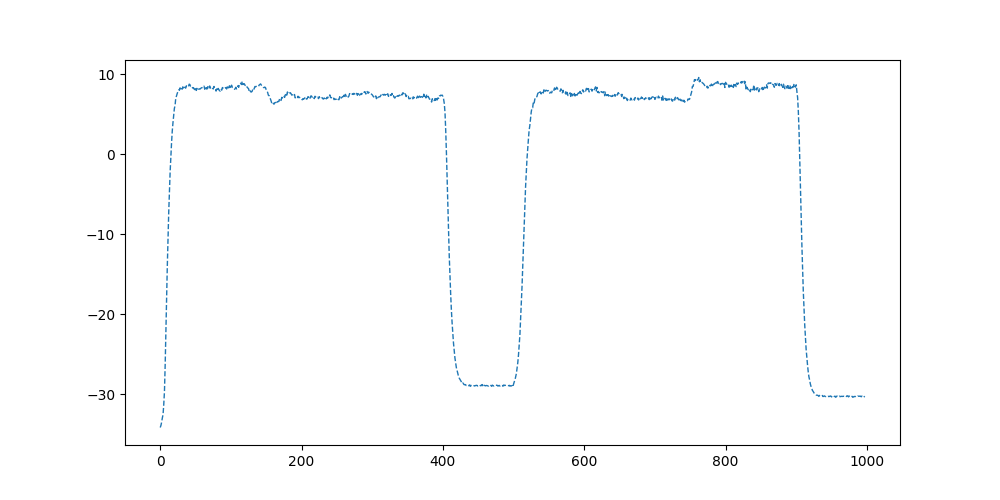

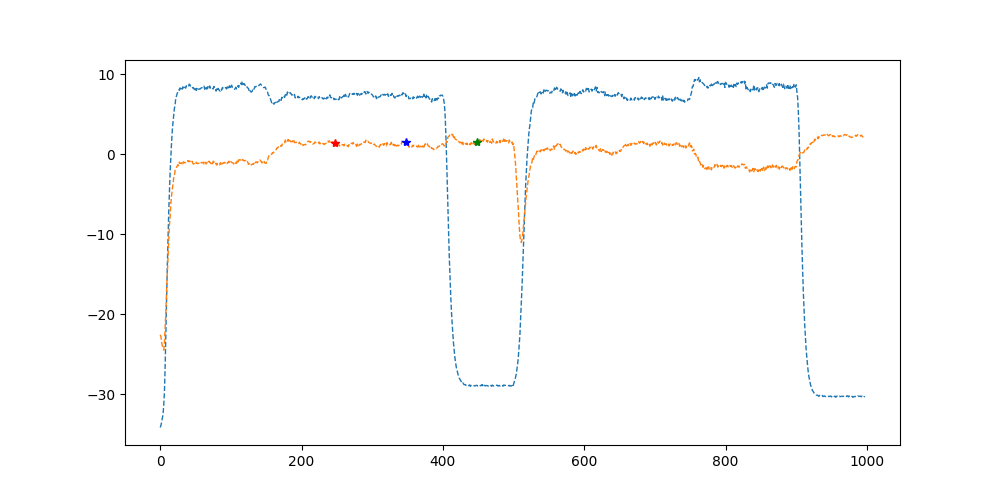

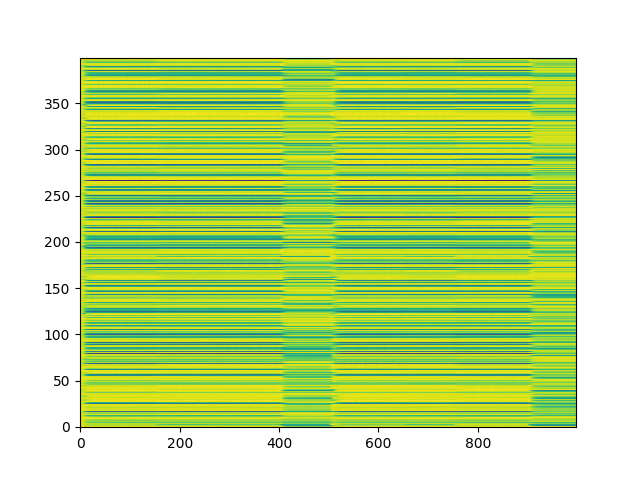

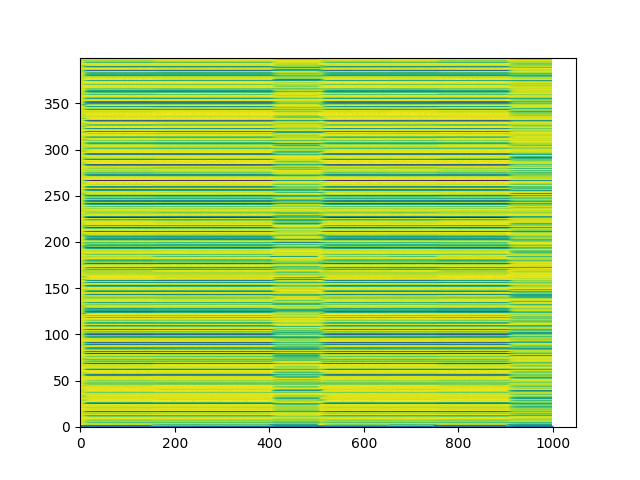

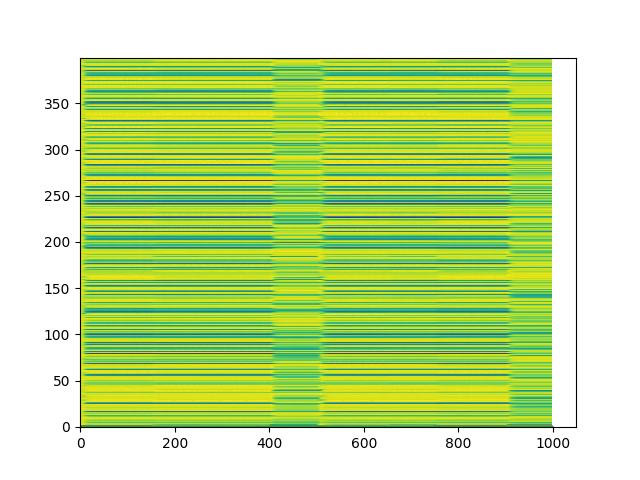

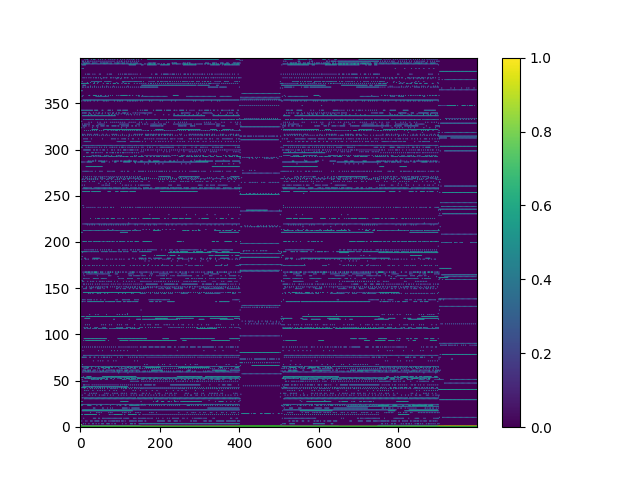

In [4]:
plt.plot(pca.numpy()[:, 0], "--", linewidth=1)
plt.show()
pca_show = 2
plt.plot(pca.numpy()[:, pca_show], "--", linewidth=1)
trialstop = 250
delay = 100
delay_beetween = 100
time = trialstop - 2
for i in range(1):

    plt.plot([time], pca.numpy()[time, pca_show], "*", c="r")
    time += delay
    plt.plot(
        [time],
        pca.numpy()[time, pca_show],
        "*",
        c="b",
    )
    time += delay_beetween
    plt.plot(
        [time],
        pca.numpy()[time, pca_show],
        "*",
        c="g",
    )
    time += trialstop
plt.show()
plt.close()

plt.imshow(v_mean.numpy()[:, 0, :].T, aspect="auto", origin="lower")
plt.show()

inputs, target_out = Task.dataset(1)

plt.plot(data[:, 0, 1].detach().cpu().numpy())
plt.show()

# plt.plot(out[:, 0, 0])
plt.plot(out[:, 0, 1])
plt.plot(out[:, 0, 2])
plt.show()

s = torch.stack(s).detach()
s = s.cpu().numpy()

plt.imshow(s[:, 0, :].T, aspect="auto", origin="lower")
plt.colorbar()
plt.show()

Using matplotlib backend: module://ipympl.backend_nbagg


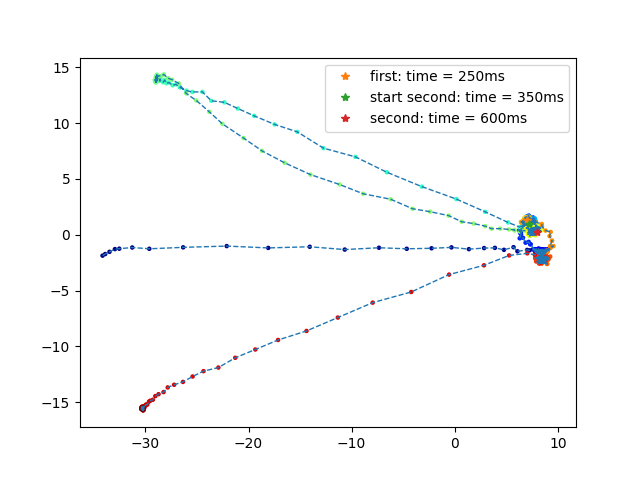

In [5]:

%matplotlib widget

first = 0
second = 1
plt.plot(pca.numpy()[:, first], pca.numpy()[:, second], "--", linewidth=1)
plt.scatter(pca.numpy()[:, first], pca.numpy()[
            :, second], c=cmap, cmap="jet", s=5)


trialstop = 250
delay = 100
delay_beetween = 100
time = trialstop
for i in range(1):

    plt.plot(
        pca.numpy()[time, first],
        pca.numpy()[time, second],
        "*",
        label=fr"first: time = {time}ms",
    )
    time += delay
    plt.plot(
        pca.numpy()[time, first],
        pca.numpy()[time, second],
        "*",
        label=fr"start second: time = {time}ms",
    )
    time += trialstop
    plt.plot(
        pca.numpy()[time, first],
        pca.numpy()[time, second],
        "*",
        label=fr"second: time = {time}ms",
    )


plt.legend()
plt.show()
plt.close()


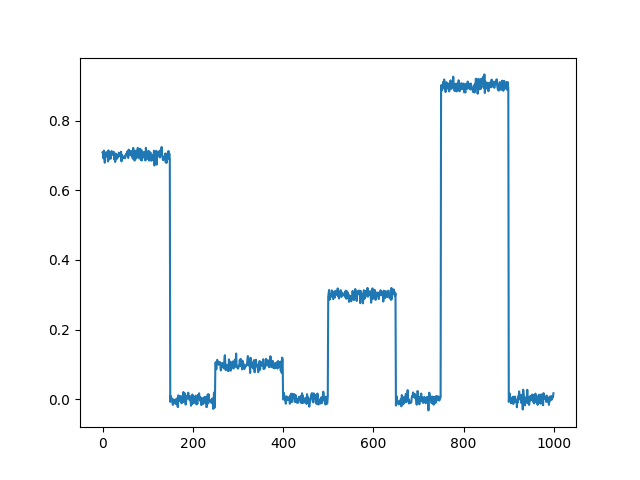

In [6]:
plt.plot(data.cpu().numpy()[:, 0, 1])